# Enhancing Topic Modeling with Open Source Large Language Models (LLMs) 🦙
*Integrate BERTopic and Mixtral 8x7B for Richer Topic Insights*

[Inspired by MAARTEN GROOTENDORST](https://maartengrootendorst.substack.com/p/topic-modeling-with-llama-2)
<br>

In this guide, we'll delve into leveraging open-source Large Language Models (LLMs) like Mistral, Zephyr, and others (including Llama 2 and Qwen for enhanced Chinese language support) for efficient Topic Modeling. Our focus will be on avoiding the exhaustive approach of processing each document with an LLM. We'll employ BERTopic, a flexible topic modeling framework that can utilize any LLM to refine topic delineations.

BERTopic simplifies the process into five clear steps: embedding documents, dimensionality reduction of embeddings, clustering of embeddings, document tokenization by cluster, and extraction of the most representative words for each topic.
<br>
<div>
<img src="https://github.com/MaartenGr/BERTopic/assets/25746895/e9b0d8cf-2e19-4bf1-beb4-4ff2d9fa5e2d" width="500"/>
</div>

With the advent of advanced LLMs like **Mistral or Gemma**, our capacity for topic modeling has greatly expanded beyond simple word lists. Direct analysis of all documents by Llama 2 is computationally impractical. Although vector databases offer a solution for search, determining the precise topics of interest remains a challenge.

We propose a novel approach: utilizing BERTopic to generate clusters and topics, then employing Mixtral to refine and enhance these into more precise topic representations.

This method merges the strengths of both worlds: BERTopic's efficient topic generation and Mixtral's refined topic representation.
<br>
<div>
<img src="https://github.com/MaartenGr/BERTopic/assets/25746895/7c7374a1-5b41-4e93-aafd-a1587367767b" width="500"/>
</div>

With our introduction complete, let's dive into the practical tutorial!


---
        
💡 **NOTE**: We will be using together.ai and the remote LLM.

---

We will start by installing a number of packages that we are going to use throughout this example:

In [ ]:
!pip install bertopic datasets -qqq

# DataMapPlot
!git clone https://github.com/TutteInstitute/datamapplot.git -q
!pip install datamapplot/. -q

# GPU-accelerated HDBSCAN + UMAP
!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com -q
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com -q
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com -q
!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64 -q

  Using cached bertopic-0.16.0-py2.py3-none-any.whl (154 kB)
  Using cached datasets-2.17.1-py3-none-any.whl (536 kB)
  Using cached hdbscan-0.8.33.tar.gz (5.2 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.2 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039282 sha256=71a69acabde9060da9fe79bfe73f4

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
  Using cached https://pypi.nvidia.com/cuml-cu12/cuml_cu12-24.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1074.6 MB)
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
  Using cached https://pypi.nvidia.com/cugraph-cu12/cugraph_cu12-24.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1311.2 MB)
Looking in links: https://pip.cupy.dev/aarch64


In [ ]:
!pip install openai

  Using cached openai-1.12.0-py3-none-any.whl (226 kB)
  Using cached httpx-0.27.0-py3-none-any.whl (75 kB)
  Using cached httpcore-1.0.4-py3-none-any.whl (77 kB)
  Using cached h11-0.14.0-py3-none-any.whl (58 kB)


# 📄 **Data**

We are going to apply topic modeling on a number of Patent abstracts. They are a great source for topic modeling since they contain a wide variety of technologies and therefore topics and are generally well-written.

In [12]:
import textwrap

In [ ]:
from datasets import load_dataset

dataset = load_dataset("RJuro/neuro_patents")['train']

# Extract abstracts to train on and corresponding titles
abstracts = dataset["appln_abstract"]
titles = dataset["appln_title"]

To give you an idea, an abstract looks like the following:

In [ ]:
# a sleeping stage monitor
print(textwrap.fill(abstracts[8765], width=80))

Provided is a sleeping state judgment method and system using a body movement
detection sensor which judges a sleeping stage using only respiratory signals
and judges the sleeping stage in a non-supine position. The sleeping state
judgment method and system is characterized in that the body movement detection
sensor stores a body movement signal generated by respiratory movement during a
unit time, obtains the frequency spectrum of the stored body movement signal,
and judges a non-sleeping state and a sleeping state according to the
distribution of higher harmonic waves in the frequency spectrum, and preferably
characterized by judging REM sleep and non-REM sleep according to the
distribution of second higher harmonic waves and third higher harmonic waves in
the frequency spectrum.


In [ ]:
len(abstracts)

16773

# 💬 **Utilizing the OpenAI Package with together.ai API**

In this tutorial segment, we'll explore the utilization of the OpenAI package, leveraging its compatibility with the together.ai API for integrating Large Language Models (LLMs). Specifically, we will focus on the Mixtral model from Mistral, which represents an optimal balance of performance (surpasses chatGPT3.5) and computational efficiency - and also price!

### Integration Steps:

1. **OpenAI Client Setup**: We initiate by configuring the OpenAI client. This setup involves specifying the together.ai API as the base URL and providing the necessary API key. The compatibility with the OpenAI format simplifies this process, allowing for a smooth integration. And later you can swap out for chatGPT or a local LLM.

2. **Model Selection and Request**: Our model of choice for this task is the Mixtral model from Mistral. Through the OpenAI package, we will craft a request that aligns with the together.ai API specifications. This step includes defining the task, such as text classification or generation, and setting parameters like temperature for controlling the output's creativity.

3. **Execution and Output Retrieval**: With the request formulated, we execute it via the OpenAI client, which communicates with the together.ai API backend. The backend, understanding the OpenAI format, efficiently processes our request using the specified Mixtral model.


In [ ]:
from google.colab import userdata

In [ ]:
from openai import OpenAI

In [13]:
TOGETHER_API_KEY = userdata.get('TOGETHER_API_KEY')

In [14]:
# Point to the local server
client = OpenAI(base_url="https://api.together.xyz/v1", api_key=TOGETHER_API_KEY)

## **Prompt Engineering**

To check whether our model is correctly loaded, let's try it out with a few prompts.

In [15]:
system = "You are a helpful assistant"
user = "Could you explain to me training dogs works as if I am 5?"

In [16]:
completion = client.chat.completions.create(
  model="NousResearch/Nous-Hermes-2-Mistral-7B-DPO", # this field is currently unused
  messages=[
    {"role": "system", "content": system},
    {"role": "user", "content": user}
  ],
  temperature=0.2,
)

In [17]:
print(textwrap.fill(completion.choices[0].message.content, width=100))

Of course! Training dogs is like teaching a little friend how to behave nicely and follow rules.
Imagine you have a new puppy named Fido. Fido wants to play and have fun, but he doesn't know some
things he should not do, like jumping on people or chewing on shoes.  So, you (the dog's owner) show
Fido what to do by using treats, praise, and patience. You teach him "sit" by holding a treat near
his nose and slowly moving it up. Fido's head will go up too, and he'll naturally sit to follow the
treat. When he sits, you say "good sit!" and give him the treat. This way, Fido learns that sitting
makes him happy because he gets treats and praise.  Over time, Fido will remember that "sit" means
he gets treats and good attention, so he'll do it more often. You keep teaching Fido other things
like "come" and "stay" using treats, praise, and patience. With practice, Fido will become a well-
behaved and happy doggy who loves to follow the rules.


### **Prompt Template**

We are going to keep our `system prompt` simple and to the point:

In [18]:
# System prompt describes information given to all conversations
system_prompt = """
You are a helpful, respectful and honest assistant for labeling scientific and technical topics - particularly withing neuroscience and neurotech.
"""

We will tell the model that it is simply a helpful assistant for labeling topics since that is our main goal.

In contrast, our `user prompt` is going to the be a bit more involved. It will consist of two components, an **example** and the **main prompt**.

Let's start with the **example**. Most LLMs do a much better job of generating accurate responses if you give them an example to work with. We will show it an accurate example of the kind of output we are expecting.

In [19]:
# Example prompt demonstrating the output we are looking for
example_prompt = """
I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
"""

example_output = """Environmental impacts of eating meat"""



This example, based on a number of keywords and documents primarily about the impact of
meat, helps to model to understand the kind of output it should give. We show the model that we were expecting only the label, which is easier for us to extract.

Next, we will create a template that we can use within BERTopic:

In [ ]:
# Our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
main_prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
"""

There are two BERTopic-specific tags that are of interest, namely `[DOCUMENTS]` and `[KEYWORDS]`:

* `[DOCUMENTS]` contain the top 5 most relevant documents to the topic
* `[KEYWORDS]` contain the top 10 most relevant keywords to the topic as generated through c-TF-IDF

This template will be filled accordingly to each topic. And finally, we can combine this into our final prompt:

In [ ]:
prompt = system_prompt + example_prompt + main_prompt

In [ ]:
print(prompt)

# 🗨️ **BERTopic**

Before we can start with topic modeling, we will first need to perform two steps:
* Pre-calculating Embeddings
* Defining Sub-models

## **Preparing Embeddings**

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

use `BAAI/bge-small-zh-v1.5`for Chinese.


🔥 **TIP**: You can find a great overview of good embeddings for clustering on the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In [20]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

## **Sub-models**

Next, we will define all sub-models in BERTopic and do some small tweaks to the number of clusters to be created, setting random states, etc.

In [57]:
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
# from umap import UMAP
# from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=3, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=25, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

As a small bonus, we are going to reduce the embeddings we created before to 2-dimensions so that we can use them for visualization purposes when we have created our topics.

In [52]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

### **Representation Models**

One of the ways we are going to represent the topics is with Zephyr which should give us a nice label. However, we might want to have additional representations to view a topic from multiple angles.

Here, we will be using c-TF-IDF as our main representation and [KeyBERT](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#keybertinspired), [MMR](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#maximalmarginalrelevance), and [Zephyr](https://maartengr.github.io/BERTopic/getting_started/representation/llm.html) as our additional representations.

In [54]:
prompt = """
I have a topic that is described by the following keywords: [KEYWORDS]
In this topic, the following documents are a small but representative subset of all documents in the topic:
[DOCUMENTS]

Based on the information above, please give a topic label of maximum 6 words:
topic: <label>
"""

In [58]:
from bertopic.representation import OpenAI

from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance

# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

openai_rep = OpenAI(client, model="NousResearch/Nous-Hermes-2-Mistral-7B-DPO",
                    chat=True,
                    prompt=prompt,
                    nr_docs=5,
                    delay_in_seconds=3)


# All representation models
representation_model = {
    "KeyBERT": keybert,
    "Mixtral": openai_rep,
    "MMR": mmr,
}

# 🔥 **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

In [59]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=15,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(abstracts, embeddings)


2024-02-23 22:53:58,223 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-23 22:53:58,509 - BERTopic - Dimensionality - Completed ✓
2024-02-23 22:53:58,511 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-23 22:53:58,991 - BERTopic - Cluster - Completed ✓
2024-02-23 22:53:59,004 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 44/44 [02:28<00:00,  3.37s/it]
2024-02-23 22:56:35,351 - BERTopic - Representation - Completed ✓


Now that we are done training our model, let's see what topics were generated:

In [60]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,Mixtral,MMR,Representative_Docs
0,-1,7292,-1_the_of_and_to,"[the, of, and, to, an, in, is, for, on, by, da...","[model, processing, detection, image, robot, d...",[AI-based image analysis and processing],"[of, and, to, an, in, for, by, data, image, me...",[An image file processing method and an appara...
1,0,3050,0_or_of_and_in,"[or, of, and, in, disease, for, the, is, inven...","[compounds, phenyl, alzheimer, compound, an, n...",[Neuropharmacology Treatment Disorders],"[of, and, disease, for, the, invention, treatm...",[A compound of formula (I) is described. The c...
2,1,713,1_word_language_speech_the,"[word, language, speech, the, text, of, words,...","[language, linguistic, model, corpus, models, ...",[Language Model Training and Natural Language ...,"[word, language, speech, text, words, model, t...",[An automatic speech recognition (ASR) system ...
3,2,615,2_vehicle_driving_driver_the,"[vehicle, driving, driver, the, data, traffic,...","[driving, vehicle, vehicles, traffic, steering...","[Autonomous Driving, Vehicle Safety, Driver As...","[vehicle, driving, driver, data, traffic, to, ...",[A safe driving support apparatus may include:...
4,3,357,3_stimulation_electrical_brain_nerve,"[stimulation, electrical, brain, nerve, patien...","[neuromodulation, neurostimulation, stimulatio...",[Neuromodulation Techniques],"[stimulation, electrical, brain, nerve, patien...",[A brain response measurement system includes ...
5,4,357,4_emotion_user_emotional_social,"[emotion, user, emotional, social, the, of, to...","[emotion, emotions, emotional, analyzing, dete...",[Emotion Recognition & Social Interaction],"[emotion, emotional, social, of, to, informati...",[ Provided is an emotion estimation device whe...
6,5,353,5_face_facial_image_feature,"[face, facial, image, feature, recognition, th...","[faces, face, facial, model, recognition, dete...",[Face recognition methods and systems],"[face, facial, image, recognition, of, model, ...",[A face recognition apparatus and method using...
7,6,344,6_brain_wave_signal_the,"[brain, wave, signal, the, eeg, to, of, signal...","[brainwaves, brainwave, electroencephalogram, ...",[Brainwave-based Control Devices],"[brain, wave, signal, the, eeg, to, signals, b...",[To provide an artificial intelligence based m...
8,7,340,7_neuron_synaptic_neural_neurons,"[neuron, synaptic, neural, neurons, network, c...","[neuromorphic, synaptic, synapses, neurons, sy...",[Neuromorphic Networks and Spike-Dependent Pla...,"[neuron, synaptic, neural, neurons, network, c...",[Systems and methods for event-driven learning...
9,8,295,8_image_object_the_of,"[image, object, the, of, network, feature, ima...","[convolutional, model, segmentation, detection...","[Object detection, image processing, AI models...","[image, object, the, network, feature, images,...",[The present application relates to the techni...


In [61]:
topic_model.get_topic(1, full=True)["KeyBERT"]

[('language', 0.8506446),
 ('linguistic', 0.85049057),
 ('model', 0.847645),
 ('corpus', 0.8445716),
 ('models', 0.8425674),
 ('representation', 0.83789873),
 ('vocabulary', 0.8346518),
 ('utterance', 0.8298728),
 ('semantic', 0.8296531),
 ('speech', 0.82765037)]

We got over 100 topics that were created and they all seem quite diverse.We can use the labels by Llama 2 and assign them to topics that we have created. Normally, the default topic representation would be c-TF-IDF, but we will focus on Llama 2 representations instead.


In [63]:
mixtral_labels = [label[0][0].split("\n")[0] for label in topic_model.get_topics(full=True)["Mixtral"].values()]
topic_model.set_topic_labels(mixtral_labels)

# 📊 **Visualize**
We can go through each topic manually, which would take a lot of work, or we can visualize them all in a single interactive graph.
BERTopic has a bunch of [visualization functions](https://medium.com/r/?url=https%3A%2F%2Fmaartengr.github.io%2FBERTopic%2Fgetting_started%2Fvisualization%2Fvisualize_documents.html) that we can use. For now, we are sticking with visualizing the documents.

In [65]:
topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)

In [47]:
import PIL
import numpy as np
import requests

# Prepare logo
bertopic_logo_response = requests.get(
    "https://raw.githubusercontent.com/MaartenGr/BERTopic/master/images/logo.png",
    stream=True,
    headers={'User-Agent': 'My User Agent 1.0'}
)
bertopic_logo = np.asarray(PIL.Image.open(bertopic_logo_response.raw))

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'left': 'Topics labeled with `Nous-Hermes-2-Mistral-7B-DPO`'}>)

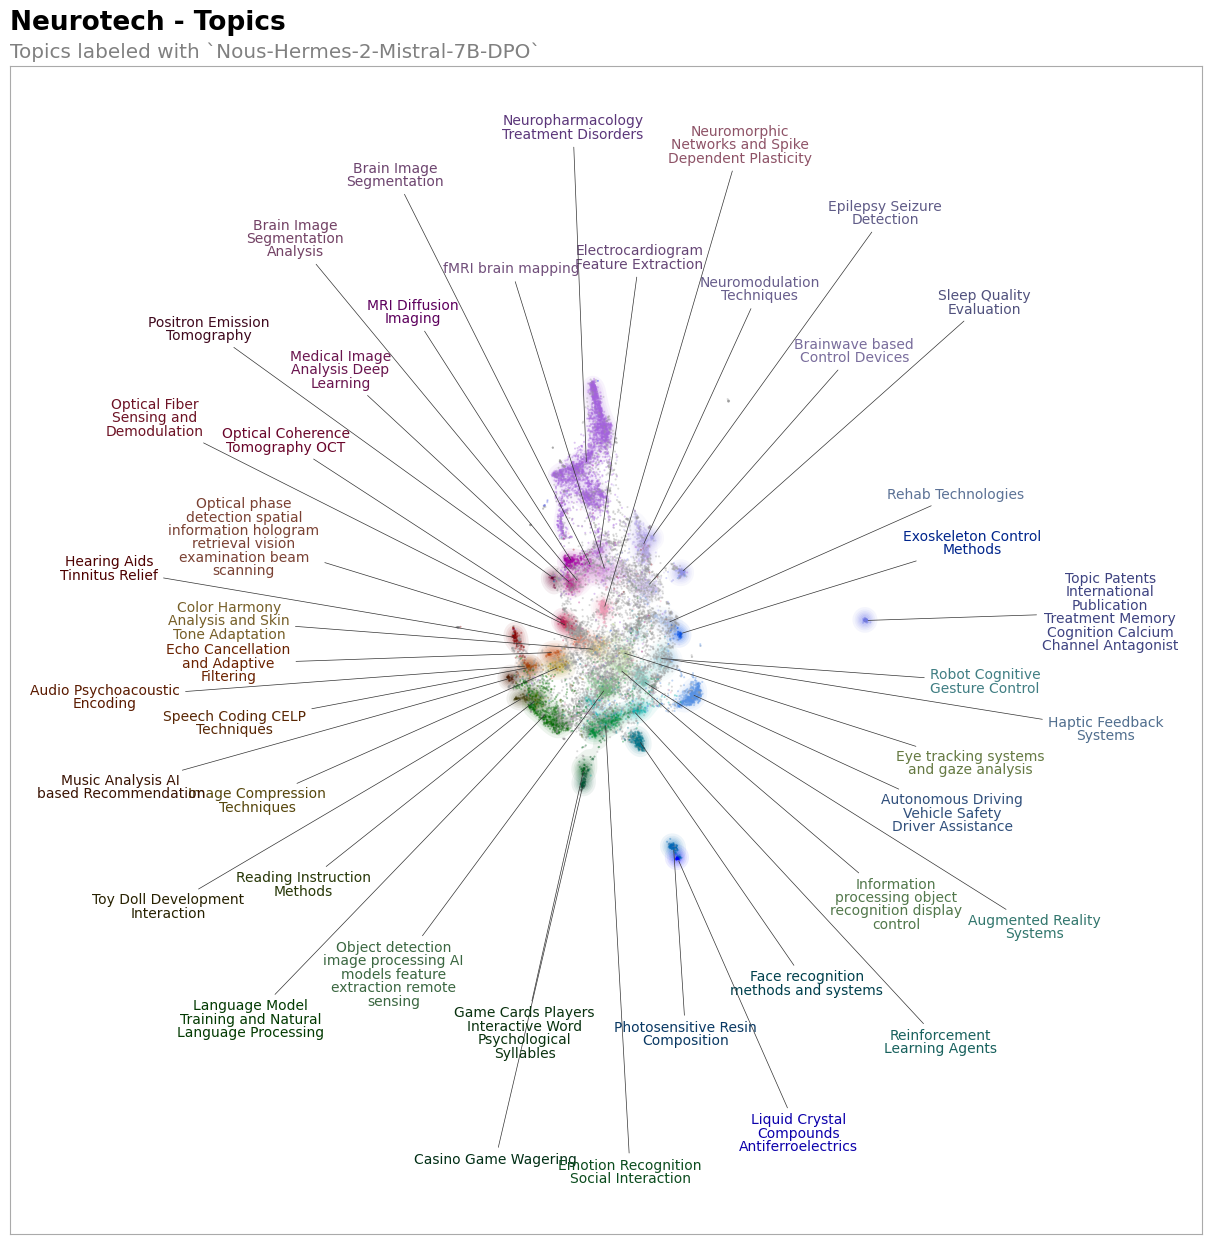

In [68]:
import datamapplot
import re

# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["Mixtral"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

# Run the visualization
datamapplot.create_plot(
    reduced_embeddings,
    all_labels,
    label_font_size=10,
    title="Neurotech - Topics",
    sub_title="Topics labeled with `Nous-Hermes-2-Mistral-7B-DPO`",
    label_wrap_width=20,
    use_medoids=True,
    #logo=bertopic_logo,
    #logo_width=0.16
)

In [ ]:
dataset.to_parquet('patents_with_tm.pq')